# **Exploratory Data Analysis on Development Indicators and CO<sub>2</sub> Emission**

## **0. Introduction**
Climate change and environmental degradation influence the status of the sustainable economy. This analysis explores the relationship between key dimensions of human development and CO<sub>2</sub> emissions in a panel setting, i.e., covering multiple countries across various years. Data is collected from the World Bank V2 Indicators API (No authentication is required). <br>
https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-api-documentation

## **1. Select countries and indicators of interest**

In [1]:
import requests
import wbgapi as wb
import pycountry_convert as pc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats

The WBGAPI package provides an easy access to the World Bank's data API. <br>
https://pypi.org/project/wbgapi/

The World Bank data portal offers global economic and development statistics. The following query lists all available databases:

In [2]:
wb.source.info()

id,name,code,concepts,lastupdated
1,Doing Business,DBS,3,2021-08-18
2,World Development Indicators,WDI,3,2023-03-30
3,Worldwide Governance Indicators,WGI,3,2022-09-23
5,Subnational Malnutrition Database,SNM,3,2016-03-21
6,International Debt Statistics,IDS,4,2022-12-06
11,Africa Development Indicators,ADI,3,2013-02-22
12,Education Statistics,EDS,3,2020-12-20
13,Enterprise Surveys,ESY,3,2022-03-25
14,Gender Statistics,GDS,3,2023-03-06
15,Global Economic Monitor,GEM,3,2020-07-27


In the following queries, we will be using the World Development Indicators (WDI) database, which is compiled from officially recognized international sources and presents the most current and accurate global development data.  

### 1.1 Select the countries of interest

We include all countries with **a population greater than 1 million** (based on 2021 data).

Check the indicator name for total population.

In [3]:
wb.series.info(q='population, total')

id,value
SP.POP.TOTL,"Population, total"
,1 elements


Initialise a list of indicators, to which we will add indicators of interest later.

In [4]:
indicators = [{"code":"SP.POP.TOTL", "name":"pop_tot", "description":"Population, total"}]

The API call starts with a base url "http://api.worldbank.org/v2/", followed by the country code, indicator code, and parameters. <br>
https://datahelpdesk.worldbank.org/knowledgebase/articles/1886674-new-features-and-enhancements-in-the-v2-api

In this API call, we fetch population data of all countries in 2021.<br>
- /country/all <br>
- /indicator/SP.POP.TOTL <br>
- ?format=json: to ensure we receive a JSON response <br>
- &date=2021 <br>
- &per_page=300: change the default page size of 50 to 300 to ensure we need only one API call because the data we are to fetch is for about 260 countries. <br>
- &ctrycode=y: gives 3-character country code

In [5]:
total_pop_url = 'http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json&date=2021&per_page=300&ctrycode=y'
pop_res = requests.get(total_pop_url)

Read the response into a dataframe `pop_df`.

In [6]:
pop = [{'country':res['country']['value'], 'code':res['countrycode'], 'population':res['value']} for res in pop_res.json()[1]]                
pop_df = pd.DataFrame(pop)

In [7]:
pop_df.head()

,country,code,population
0,Africa Eastern and Southern,AFE,702976832.0
1,Africa Western and Central,AFW,478185907.0
2,Arab World,ARB,456520777.0
3,Caribbean small states,CSS,7481877.0
4,Central Europe and the Baltics,CEB,101430997.0


The 'country' field contains not only individual countries but also aggregates. We need to filter out the aggregates. 

Check the location of the first individual country: Afgahnistan.

In [8]:
np.where(pop_df.country == 'Afghanistan')

(array([49], dtype=int64),)

View the head of the dataframe to ensure "country" values before "Afghanistan" are all aggregates.

In [9]:
pop_df.iloc[:59,]

,country,code,population
0,Africa Eastern and Southern,AFE,7.029768e+08
1,Africa Western and Central,AFW,4.781859e+08
2,Arab World,ARB,4.565208e+08
3,Caribbean small states,CSS,7.481877e+06
4,Central Europe and the Baltics,CEB,1.014310e+08
5,Early-demographic dividend,EAR,3.411889e+09
6,East Asia & Pacific,EAS,2.370204e+09
7,East Asia & Pacific (excluding high income),EAP,2.123673e+09
8,East Asia & Pacific (IDA & IBRD countries),TEA,2.097669e+09
9,Euro area,EMU,3.430678e+08


Subset `pop_df` to include only individual countries.

In [10]:
pop_df = pop_df.iloc[49:,].reset_index().drop('index', axis = 1)

In [11]:
pop_df.describe()

,population
count,2.170000e+02
mean,3.624388e+07
std,1.405057e+08
min,1.120400e+04
25%,8.045670e+05
50%,6.691800e+06
75%,2.568808e+07
max,1.412360e+09


Select countries with a population greater than 1 million.

In [12]:
pop_df = pop_df[pop_df['population'] > 1000000].reset_index().drop('index', axis = 1)
pop_df.shape

(160, 3)

In [13]:
pop_df.describe()

,population
count,1.600000e+02
mean,4.906751e+07
std,1.618306e+08
min,1.105557e+06
25%,5.183551e+06
50%,1.152026e+07
75%,3.623194e+07
max,1.412360e+09


**pycountry-convert** is a handy tool that provides conversion functions between ISO country names, country-codes, and continent names. <br>
https://pypi.org/project/pycountry-convert/ <br>
This fuction converts 3-charactor country code to continent name.

In [14]:
def alpha3_to_continent(country_code):
    country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    return country_continent_code

Add a 'continent' column to the `pop_df` dataframe.

In [15]:
continents = []
for code in pop_df.code:
    try:
        continent = alpha3_to_continent(code)
    except:
        continent = np.nan
    continents.append(continent)

In [16]:
pop_df['continent'] = continents
pop_df[pop_df['continent'].isnull()]

,country,code,population,continent
77,Kosovo,XKX,1786038.0,NaN
141,Timor-Leste,TLS,1320942.0,NaN


Two of the countrie codes could not be coverted to a continent name. These two countries' independence might be controversial, so we remove them from the dataframe.

In [17]:
pop_df = pop_df.drop([77,141])

In [18]:
pop_df.continent.unique()

array(['AS', 'EU', 'AF', 'SA', 'OC', 'NA'], dtype=object)

Replace the continent codes with continent names:

In [19]:
dict = {'AS':'Asia', 'EU':'Europe', 'AF':'Africa', 'SA': 'South America', 'OC':'Oceania', 'NA':'North America'}
pop_df['continent'].replace(dict, inplace = True)

Finally the `pop_df` dataframe have the countries of interest, their codes and continents. <br>
Extract the country codes as a list (for API calls).

In [20]:
country_codes = list(pop_df['code'])

In [21]:
print(country_codes)

['AFG', 'ALB', 'DZA', 'AGO', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BHR', 'BGD', 'BLR', 'BEL', 'BEN', 'BOL', 'BIH', 'BWA', 'BRA', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COD', 'COG', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE', 'DNK', 'DJI', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FIN', 'FRA', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GRC', 'GTM', 'GIN', 'GNB', 'HTI', 'HND', 'HKG', 'HUN', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LTU', 'MDG', 'MWI', 'MYS', 'MLI', 'MRT', 'MUS', 'MEX', 'MDA', 'MNG', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NLD', 'NZL', 'NIC', 'NER', 'NGA', 'MKD', 'NOR', 'OMN', 'PAK', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'POL', 'PRT', 'PRI', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN', 'SRB', 'SLE', 'SGP', 'SVK', 'SVN', 'SOM', 'ZAF', 'SSD', 'ESP', 'LKA', 'SDN', 'SWE', 'CHE', 'SYR', 'TJK', 'TZA', 'THA', 'TGO', 'TTO', 'TUN'

### **1.2 Select the indicators of interest**

The Human Development Index (HDI), produced by the Human Development Report Office of the United Nations Development Programme (UNDP), is a summary measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and having a decent standard of living. <br>
https://en.wikipedia.org/wiki/Human_Development_Index 
 
We first select the indicators constructing Human Development Index:

a. A decent standard of living: _GNI per capita_ <br>
&emsp; (the dollar value of a country's final income in a year divided by its population)

Query for indictor code:

In [22]:
wb.series.info(q='GNI per capita')

id,value
NY.GNP.PCAP.CD,"GNI per capita, Atlas method (current US$)"
NY.GNP.PCAP.CN,GNI per capita (current LCU)
NY.GNP.PCAP.KD,GNI per capita (constant 2015 US$)
NY.GNP.PCAP.KD.ZG,GNI per capita growth (annual %)
NY.GNP.PCAP.KN,GNI per capita (constant LCU)
NY.GNP.PCAP.PP.CD,"GNI per capita, PPP (current international $)"
NY.GNP.PCAP.PP.KD,"GNI per capita, PPP (constant 2017 international $)"
,7 elements


Append the indicator to the list of indicators:

In [23]:
indicators.append({"code":"NY.GNP.PCAP.CD", "name":"GNI", "description":"GNI per capita, Atlas method (current US$)"})

b. A long and healthy life: _Life expectancy at birth_ 

In [24]:
wb.series.info(q='life expectancy')

id,value
SP.DYN.LE00.FE.IN,"Life expectancy at birth, female (years)"
SP.DYN.LE00.IN,"Life expectancy at birth, total (years)"
SP.DYN.LE00.MA.IN,"Life expectancy at birth, male (years)"
,3 elements


In [25]:
indicators.append({"code":"SP.DYN.LE00.IN", "name":"life_exp", "description":"Life expectancy at birth, total (years)"})


The HDI indicators for education: _Mean years of schooling and expected years of schooling_ is not available in the World Bank database.<br>
We choose c. _Compusory education duration_ and d. _Tertiary school enrollment_ as proxies. 

In [26]:
wb.series.info(q='education, duration')

id,value
SE.COM.DURS,"Compulsory education, duration (years)"
SE.PRE.DURS,"Preprimary education, duration (years)"
SE.PRM.DURS,"Primary education, duration (years)"
SE.SEC.DURS,"Secondary education, duration (years)"
,4 elements


In [27]:
indicators.append({"code":"SE.COM.DURS", "name":"min_edu", "description":"Compulsory education, duration (years)"})

In [28]:
wb.series.info(q='enrollment, tertiary')

id,value
SE.ENR.TERT.FM.ZS,"School enrollment, tertiary (gross), gender parity index (GPI)"
SE.TER.ENRR,"School enrollment, tertiary (% gross)"
SE.TER.ENRR.FE,"School enrollment, tertiary, female (% gross)"
SE.TER.ENRR.MA,"School enrollment, tertiary, male (% gross)"
,4 elements


In [29]:
indicators.append({"code":"SE.TER.ENRR", "name":"tert_enroll", "description":"School enrollment, tertiary (% gross)"})

We then add the indicator for CO2 emission: CO2 emissions (metric tons per capita)

In [30]:
wb.series.info(q='co2 emissions')

id,value
EN.ATM.CO2E.GF.KT,CO2 emissions from gaseous fuel consumption (kt)
EN.ATM.CO2E.GF.ZS,CO2 emissions from gaseous fuel consumption (% of total)
EN.ATM.CO2E.KD.GD,CO2 emissions (kg per 2015 US$ of GDP)
EN.ATM.CO2E.KT,CO2 emissions (kt)
EN.ATM.CO2E.LF.KT,CO2 emissions from liquid fuel consumption (kt)
EN.ATM.CO2E.LF.ZS,CO2 emissions from liquid fuel consumption (% of total)
EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita)
EN.ATM.CO2E.PP.GD,CO2 emissions (kg per PPP $ of GDP)
EN.ATM.CO2E.PP.GD.KD,CO2 emissions (kg per 2017 PPP $ of GDP)
EN.ATM.CO2E.SF.KT,CO2 emissions from solid fuel consumption (kt)


In [31]:
indicators.append({"code":"EN.ATM.CO2E.PC", "name":"co2", "description":"CO2 emissions (metric tons per capita)"})

Natural resources rents are the sum of oil rents, natural gas rents, coal rents (hard and soft), mineral rents, and forest rents.  Countries earning high natural resources rents are typically fossil fuel and/or mineral exporters. <br>
("Rent" here means economic rent: the difference between the price at which an output from a resource can be sold and its respective extraction and production costs, including normal return.)<br>
Finally we include f. _Total natural resources rents (% of GDP)_ into our analysis.

In [32]:
wb.series.info(q='natural resources')

id,value
NY.ADJ.DRES.GN.ZS,Adjusted savings: natural resources depletion (% of GNI)
NY.GDP.TOTL.RT.ZS,Total natural resources rents (% of GDP)
,2 elements


In [33]:
indicators.append({"code":"NY.GDP.TOTL.RT.ZS", "name":"nat_res", "description":"Total natural resources rents (% of GDP)"})

In [34]:
indicator_df = pd.DataFrame(indicators)

Extract the indicator codes as a list (for API calls).

In [35]:
indicator_codes = [*indicator_df.code]

## **2. Retrieving data from API**

Specify the year range in the API call url: from 1981 to 2020

In [36]:
base_url = 'http://api.worldbank.org/v2/'
params = '?format=json&date=1981:2020'

In [37]:
column_names = [*indicator_df.name] + ['year']

In [38]:
print(column_names)

['pop_tot', 'GNI', 'life_exp', 'min_edu', 'tert_enroll', 'co2', 'nat_res', 'year']


Get JSON data from the endpoint:

In [39]:
df_ls = []
err_ls =[]

# iterate over each country code in the country_codes list
for country_code in country_codes:
    data_ls = []
    
    # iterate over each indicator code in the indicator_codes list
    for indicator in indicator_codes: 
        
        # form the URL for API call
        url = base_url + 'countries/' + country_code.lower() + '/indicators/' + indicator + params
        
        # send the request 
        response = requests.get(url)
        
        # validate the response status code
        if response.status_code == 200:
            
            # list of values for one indicator
            values = []
            
            # check if the length of the response is >1
            if len(response.json()) > 1:        
                
                # iterate over each object in the response
                for obj in response.json()[1]:
                    
                    # check for empty values
                    if obj['value'] == "" or obj['value'] == None:
                        values.append(np.nan)
                    else:
                    # add the value to the list of indicator values
                         values.append(float(obj['value']))
                data_ls.append(values)
            else:
            # print an error message if the API call failed
                print("Error Status Code: " + str(response.status_code))

    # Once all the indicator values have been obtained, add the values for "year"
    data_ls.append([year for year in range(2020, 1980, -1)])
    # construct a dataframe for each country
    df = pd.DataFrame(data_ls).T
    try:    
        df.columns = column_names
        df['code'] = country_code
        display(df.head(1))
        df_ls.append(df)
    except:
        err_ls.append(country_code)
        print("Column Error:" + str(country_code))

,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,38972230.0,500.0,62.575,9.0,10.56252,NaN,0.653622,2020.0,AFG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2837849.0,5260.0,76.989,9.0,57.813141,NaN,1.253772,2020.0,ALB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,43451666.0,3600.0,74.453,10.0,52.498619,NaN,11.925719,2020.0,DZA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,33428486.0,1740.0,62.261,6.0,NaN,NaN,25.517963,2020.0,AGO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,45376763.0,9010.0,75.892,14.0,99.166267,NaN,1.828569,2020.0,ARG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2805608.0,4470.0,72.173,12.0,50.816608,NaN,2.483281,2020.0,ARM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,25655289.0,53620.0,83.2,10.0,114.189888,NaN,5.918442,2020.0,AUS


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,8916864.0,48990.0,81.192683,13.0,87.211388,NaN,0.088677,2020.0,AUT


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10093121.0,4480.0,66.868,10.0,35.24844,NaN,18.801753,2020.0,AZE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1477469.0,22950.0,79.174,9.0,60.315861,NaN,8.682727,2020.0,BHR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,167420951.0,2300.0,71.968,5.0,23.965433,NaN,0.318968,2020.0,BGD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9379952.0,6400.0,74.226829,9.0,86.596931,NaN,1.698519,2020.0,BLR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,11538604.0,46030.0,80.795122,12.0,80.888748,NaN,0.01626,2020.0,BEL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,12643123.0,1230.0,60.088,6.0,11.08936,NaN,2.321623,2020.0,BEN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,11936162.0,3120.0,64.467,14.0,NaN,NaN,2.987905,2020.0,BOL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3318407.0,6030.0,76.225,9.0,37.919979,NaN,0.770192,2020.0,BIH


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2546402.0,6010.0,65.647,NaN,26.088921,NaN,0.678483,2020.0,BWA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,213196304.0,7820.0,74.009,14.0,54.5728,NaN,3.991161,2020.0,BRA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6934015.0,9520.0,73.607317,11.0,75.4058,NaN,0.587944,2020.0,BGR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,21522626.0,750.0,59.731,10.0,7.84373,NaN,8.96317,2020.0,BFA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,12220227.0,220.0,61.566,NaN,4.96803,NaN,12.408516,2020.0,BDI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,16396860.0,1530.0,70.416,NaN,12.894094,NaN,1.016476,2020.0,KHM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,26491087.0,1520.0,60.833,6.0,NaN,NaN,4.678371,2020.0,CMR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,38037204.0,43540.0,81.74878,10.0,79.516922,NaN,1.495781,2020.0,CAN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5343020.0,460.0,54.604,10.0,NaN,NaN,9.322768,2020.0,CAF


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,16644701.0,630.0,52.777,10.0,NaN,NaN,15.756875,2020.0,TCD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,19300315.0,12990.0,79.377,12.0,91.66935,NaN,2.972394,2020.0,CHL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1.411100e+09,10520.0,78.077,9.0,58.420101,NaN,1.089575,2020.0,CHN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,50930662.0,5820.0,74.769,12.0,54.239288,NaN,3.782744,2020.0,COL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,92853164.0,540.0,59.739,6.0,7.00149,NaN,14.884275,2020.0,COD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5702174.0,1760.0,63.785,10.0,NaN,NaN,37.394862,2020.0,COG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5123105.0,11520.0,79.277,13.0,NaN,NaN,0.921519,2020.0,CRI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,26811790.0,2240.0,59.032,10.0,9.91299,NaN,2.024549,2020.0,CIV


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4047680.0,14820.0,77.72439,8.0,68.096481,NaN,0.521396,2020.0,HRV


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,11300698.0,NaN,77.567,9.0,46.717949,NaN,0.635243,2020.0,CUB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1237537.0,26600.0,81.391,10.0,92.937759,NaN,0.005856,2020.0,CYP


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10697858.0,21800.0,78.226829,10.0,68.061813,NaN,0.438722,2020.0,CZE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5831404.0,62710.0,81.55122,10.0,82.839287,NaN,0.219521,2020.0,DNK


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1090156.0,2830.0,62.694,10.0,NaN,NaN,0.299294,2020.0,DJI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10999664.0,7170.0,72.889,15.0,NaN,NaN,1.372377,2020.0,DOM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,17588595.0,5560.0,72.153,15.0,52.587811,NaN,4.756665,2020.0,ECU


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,107465134.0,2860.0,70.99,12.0,NaN,NaN,2.691018,2020.0,EGY


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6292731.0,3740.0,71.061,15.0,NaN,NaN,0.755814,2020.0,SLV


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1596049.0,5100.0,60.708,6.0,NaN,NaN,23.352421,2020.0,GNQ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3555868.0,NaN,67.133,8.0,NaN,NaN,NaN,2020.0,ERI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1329522.0,23570.0,78.346341,9.0,NaN,NaN,1.090707,2020.0,EST


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1180655.0,3360.0,59.692,7.0,NaN,NaN,3.920478,2020.0,SWZ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,117190911.0,880.0,65.371,8.0,NaN,NaN,5.087964,2020.0,ETH


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5529543.0,50100.0,82.131707,10.0,95.04789,NaN,0.370886,2020.0,FIN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,67571107.0,39440.0,82.17561,13.0,69.346382,NaN,0.031349,2020.0,FRA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2292573.0,6830.0,66.531,10.0,NaN,NaN,17.686703,2020.0,GAB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2573995.0,700.0,62.612,9.0,NaN,NaN,2.818368,2020.0,GMB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3722716.0,4260.0,72.765,9.0,66.689217,NaN,0.814814,2020.0,GEO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,83160871.0,48050.0,80.941463,13.0,72.989197,NaN,0.090972,2020.0,DEU


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,32180401.0,2230.0,64.114,11.0,18.68745,NaN,9.470521,2020.0,GHA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10698599.0,17960.0,81.087805,10.0,150.876068,NaN,0.056957,2020.0,GRC


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,16858333.0,4490.0,71.797,16.0,NaN,NaN,1.337368,2020.0,GTM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,13205153.0,960.0,59.327,6.0,5.84112,NaN,4.125658,2020.0,GIN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2015828.0,740.0,59.999,9.0,NaN,NaN,10.526416,2020.0,GNB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,11306801.0,1330.0,64.052,6.0,NaN,NaN,0.569149,2020.0,HTI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10121763.0,2150.0,71.462,12.0,NaN,NaN,1.211571,2020.0,HND


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,7481000.0,48550.0,85.387805,9.0,84.392418,NaN,0.000702,2020.0,HKG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9750149.0,16030.0,75.617073,13.0,55.15554,NaN,0.257879,2020.0,HUN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1.396387e+09,1890.0,70.15,8.0,29.441326,NaN,1.864573,2020.0,IND


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,271857970.0,3900.0,68.808,9.0,NaN,NaN,2.762102,2020.0,IDN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,87290193.0,3290.0,74.832,9.0,58.222488,NaN,22.342212,2020.0,IRN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,42556984.0,4720.0,69.123,6.0,NaN,NaN,32.419089,2020.0,IRQ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4985382.0,65330.0,82.204878,10.0,74.680313,NaN,0.021991,2020.0,IRL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9215100.0,43310.0,82.7,15.0,61.073029,NaN,0.106087,2020.0,ISR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,59438851.0,32410.0,82.343902,12.0,69.465279,NaN,0.076596,2020.0,ITA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2820436.0,4900.0,71.869,6.0,NaN,NaN,0.205821,2020.0,JAM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,126261000.0,40810.0,84.61561,9.0,NaN,NaN,0.097716,2020.0,JPN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10928721.0,4070.0,75.184,10.0,33.558128,NaN,0.032551,2020.0,JOR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,18755666.0,8710.0,71.37,9.0,70.67794,NaN,15.54006,2020.0,KAZ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,51985780.0,1900.0,62.675,12.0,NaN,NaN,1.224365,2020.0,KEN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,25867467.0,NaN,73.274,12.0,NaN,NaN,NaN,2020.0,PRK


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,51836239.0,33040.0,83.426829,9.0,102.467361,NaN,0.103833,2020.0,KOR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4360444.0,NaN,76.92,9.0,61.133869,NaN,32.008346,2020.0,KWT


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6579900.0,1180.0,71.8,10.0,46.451931,NaN,11.212834,2020.0,KGZ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,7319399.0,2470.0,68.497,9.0,13.48082,NaN,3.143116,2020.0,LAO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1900449.0,18240.0,75.387805,11.0,94.510834,NaN,1.263618,2020.0,LVA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5662923.0,6400.0,77.804,10.0,NaN,NaN,0.002857,2020.0,LBN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2254100.0,1150.0,54.693,7.0,NaN,NaN,5.095572,2020.0,LSO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5087584.0,600.0,60.948,6.0,NaN,NaN,15.664488,2020.0,LBR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6653942.0,7890.0,72.472,9.0,NaN,NaN,22.740316,2020.0,LBY


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2794885.0,19680.0,74.929268,11.0,70.786903,NaN,0.311968,2020.0,LTU


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,28225177.0,460.0,65.182,5.0,5.52721,NaN,5.338498,2020.0,MDG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,19377061.0,580.0,63.717,8.0,NaN,NaN,3.971258,2020.0,MWI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,33199993.0,10320.0,75.938,6.0,42.567215,NaN,5.233024,2020.0,MYS


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,21224040.0,790.0,58.633,9.0,NaN,NaN,9.367586,2020.0,MLI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4498604.0,1790.0,64.532,9.0,5.87462,NaN,2.476495,2020.0,MRT


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1265740.0,9940.0,74.177073,11.0,44.260189,NaN,0.002878,2020.0,MUS


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,125998302.0,8750.0,70.133,14.0,44.80859,NaN,2.089905,2020.0,MEX


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2635130.0,4490.0,70.166,12.0,57.97578,NaN,0.235164,2020.0,MDA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3294335.0,3720.0,72.141,12.0,66.605644,NaN,14.779009,2020.0,MNG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,36688772.0,3250.0,73.92,9.0,40.622082,NaN,0.324711,2020.0,MAR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,31178239.0,470.0,61.172,NaN,NaN,NaN,11.701827,2020.0,MOZ


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,53423198.0,1370.0,66.797,5.0,NaN,NaN,4.414429,2020.0,MMR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2489098.0,4650.0,62.829,7.0,27.2596,NaN,2.013914,2020.0,NAM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,29348627.0,1180.0,69.246,9.0,14.219507,NaN,0.514043,2020.0,NPL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,17441500.0,50170.0,81.409756,13.0,92.012177,NaN,0.15314,2020.0,NLD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5090200.0,41480.0,82.056098,10.0,79.907837,NaN,1.453263,2020.0,NZL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6755895.0,1740.0,71.795,7.0,NaN,NaN,1.632721,2020.0,NIC


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,24333639.0,550.0,61.451,NaN,4.37344,NaN,5.566564,2020.0,NER


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,208327405.0,2020.0,52.887,9.0,NaN,NaN,6.22917,2020.0,NGA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2072531.0,5730.0,75.693171,13.0,43.017288,NaN,0.559322,2020.0,MKD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5379475.0,77880.0,83.209756,10.0,84.443672,NaN,6.057298,2020.0,NOR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4543399.0,17110.0,74.757,10.0,45.48008,NaN,20.965071,2020.0,OMN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,227196741.0,1420.0,66.269,12.0,NaN,NaN,0.891482,2020.0,PAK


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4294396.0,12470.0,76.657,11.0,44.382851,NaN,0.119747,2020.0,PAN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9749640.0,2470.0,65.787,NaN,NaN,NaN,10.780752,2020.0,PNG


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6618695.0,5550.0,73.182,13.0,NaN,NaN,1.633781,2020.0,PRY


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,33304756.0,6000.0,73.665,14.0,NaN,NaN,2.316406,2020.0,PER


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,112190977.0,3350.0,72.119,13.0,33.365307,NaN,0.743295,2020.0,PHL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,37899070.0,15300.0,76.6,10.0,70.477127,NaN,0.620175,2020.0,POL


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10297081.0,21850.0,80.97561,12.0,70.382088,NaN,0.198843,2020.0,PRT


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3281538.0,21240.0,78.041,13.0,NaN,NaN,0.0,2020.0,PRI


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2760385.0,58370.0,79.099,9.0,20.79294,NaN,14.981657,2020.0,QAT


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,19265250.0,12700.0,74.353659,10.0,53.230839,NaN,0.634189,2020.0,ROU


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,144073139.0,10740.0,71.33878,11.0,NaN,NaN,10.158279,2020.0,RUS


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,13146362.0,760.0,66.774,6.0,7.26614,NaN,3.896856,2020.0,RWA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,35997107.0,21540.0,76.239,9.0,70.631981,NaN,18.212123,2020.0,SAU


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,16436120.0,1460.0,68.006,11.0,14.03411,NaN,3.207279,2020.0,SEN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6899126.0,7440.0,74.229268,8.0,68.143112,NaN,1.007055,2020.0,SRB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,8233970.0,490.0,59.763,9.0,NaN,NaN,7.806497,2020.0,SLE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5685807.0,55010.0,83.743902,6.0,93.134773,NaN,0.000222,2020.0,SGP


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5458827.0,19180.0,76.865854,10.0,47.623589,NaN,0.222296,2020.0,SVK


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,2102419.0,25400.0,80.531707,9.0,79.920837,NaN,0.213282,2020.0,SVN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,16537016.0,410.0,55.967,NaN,NaN,NaN,14.811094,2020.0,SOM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,58801927.0,6090.0,65.252,9.0,24.2363,NaN,3.911466,2020.0,ZAF


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10606227.0,NaN,55.48,8.0,NaN,NaN,NaN,2020.0,SSD


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,47365655.0,27130.0,82.334146,10.0,95.964867,NaN,0.044993,2020.0,ESP


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,21919000.0,3930.0,76.393,11.0,21.61237,NaN,0.089338,2020.0,LKA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,44440486.0,630.0,65.614,8.0,NaN,NaN,12.397978,2020.0,SDN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,10353442.0,54740.0,82.407317,10.0,84.51622,NaN,0.40603,2020.0,SWE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,8638167.0,82740.0,83.1,11.0,65.334091,NaN,0.009076,2020.0,CHE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,20772595.0,760.0,72.14,9.0,NaN,NaN,NaN,2020.0,SYR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9543207.0,1050.0,67.994,9.0,NaN,NaN,5.729407,2020.0,TJK


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,61704518.0,1050.0,66.408,7.0,7.83072,NaN,3.861777,2020.0,TZA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,71475664.0,6900.0,79.274,9.0,42.637001,NaN,1.300975,2020.0,THA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,8442580.0,900.0,61.035,10.0,15.40007,NaN,4.312561,2020.0,TGO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,1518147.0,13830.0,74.406,7.0,NaN,NaN,5.774088,2020.0,TTO


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,12161723.0,3230.0,75.292,9.0,32.756001,NaN,1.384909,2020.0,TUN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,84135428.0,9070.0,75.85,12.0,117.113152,NaN,0.404201,2020.0,TUR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,6250438.0,NaN,68.687,12.0,15.61022,NaN,NaN,2020.0,TKM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,44404611.0,740.0,62.851,7.0,NaN,NaN,7.274037,2020.0,UGA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,44132049.0,3570.0,71.185122,11.0,NaN,NaN,1.455548,2020.0,UKR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,9287289.0,41770.0,78.946,12.0,53.716019,NaN,11.943936,2020.0,ARE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,67081000.0,38590.0,80.902439,11.0,69.483727,NaN,0.389184,2020.0,GBR


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,331501080.0,64650.0,77.280488,12.0,87.567657,NaN,0.416557,2020.0,USA


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,3429086.0,15950.0,78.43,14.0,67.883209,NaN,2.266876,2020.0,URY


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,34232050.0,1740.0,70.331,12.0,15.92048,NaN,11.565149,2020.0,UZB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,28490453.0,NaN,71.095,17.0,NaN,NaN,NaN,2020.0,VEN


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,96648685.0,3450.0,75.378,10.0,NaN,NaN,2.618723,2020.0,VNM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,4803269.0,3700.0,74.403,10.0,43.097672,NaN,0.0,2020.0,PSE


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,32284046.0,NaN,64.65,9.0,NaN,NaN,NaN,2020.0,YEM


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,18927715.0,1130.0,62.38,7.0,NaN,NaN,11.807857,2020.0,ZMB


,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,15669666.0,1460.0,61.124,7.0,NaN,NaN,6.800246,2020.0,ZWE


Check the error log:

In [40]:
err_ls 

[]

Check the data quality using the data of US and NZ as samples:

In [41]:
df_ls[country_codes.index('USA')]

,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,331501080.0,64650.0,77.280488,12.0,87.567657,NaN,0.416557,2020.0,USA
1,328329953.0,66130.0,78.787805,12.0,87.888710,14.673411,0.574773,2019.0,USA
2,326838199.0,63460.0,78.639024,12.0,88.299179,15.222548,0.671278,2018.0,USA
3,325122128.0,59220.0,78.539024,12.0,88.167389,14.823261,0.441880,2017.0,USA
4,323071755.0,57140.0,78.539024,12.0,88.835052,15.149885,0.303224,2016.0,USA
5,320738994.0,56620.0,78.690244,12.0,88.889412,15.560035,0.235256,2015.0,USA
6,318386329.0,55800.0,78.841463,12.0,88.626869,16.040921,0.676357,2014.0,USA
7,316059947.0,53990.0,78.741463,12.0,88.726418,16.111184,0.806682,2013.0,USA
8,313877662.0,52790.0,78.741463,12.0,NaN,15.789783,0.862395,2012.0,USA
9,311583481.0,50620.0,78.641463,12.0,NaN,16.604218,1.326783,2011.0,USA


In [42]:
df_ls[country_codes.index('NZL')]

,pop_tot,GNI,life_exp,min_edu,tert_enroll,co2,nat_res,year,code
0,5090200.0,41480.0,82.056098,10.0,79.907837,NaN,1.453263,2020.0,NZL
1,4979200.0,43050.0,81.707317,10.0,80.302551,6.830414,1.521985,2019.0,NZL
2,4900600.0,41650.0,81.858537,10.0,82.983032,6.603273,1.445672,2018.0,NZL
3,4813600.0,38870.0,81.658537,10.0,82.033218,6.841034,1.507290,2017.0,NZL
4,4714100.0,39440.0,81.612439,10.0,81.770393,6.616321,1.030404,2016.0,NZL
5,4609400.0,40660.0,81.456829,10.0,80.563377,7.003080,1.302348,2015.0,NZL
6,4516500.0,41680.0,81.404878,10.0,77.981300,7.078490,1.408539,2014.0,NZL
7,4442100.0,39930.0,81.407317,10.0,77.262787,7.179037,1.550718,2013.0,NZL
8,4408100.0,36700.0,81.156098,10.0,127.811874,7.284318,1.751454,2012.0,NZL
9,4384000.0,32230.0,80.904878,10.0,132.069641,6.909216,2.182369,2011.0,NZL


<font color = 'purple'> Data for CO2 emission seems to be only available from 1990 to 2019 <br>
"Compulsory education duration" and "Tertiary enrollment" have many missing values. We will not use these two columns in time-series analysis.</font>

`GNI` and `pop_tot` will be used as weightings in aggregate calculations. To ensure there are enough valid data points in these two columns, we exclude any countries having more than half missing values for `GNI` or `pop_tot`.

Check the missing values in the `pop_tot` column:

In [43]:
null_pop = [(df.pop_tot.isnull().sum() >= 20) for df in df_ls]
np.where(null_pop)[0]

array([], dtype=int64)

Check the missing values in the `GNI` column:

In [44]:
null_gni = [(df.GNI.isnull().sum() >= 20) for df in df_ls]
np.where(null_gni)[0]

array([  0,  38,  44,  55,  75,  83,  84, 117, 128, 130], dtype=int64)

There are 10 countries having more than 20 missing `GNI` values. <br>
Narrow down to those countries with more than 10 missing `GNI` values in recent 20 years:

In [45]:
null_gni = [(df.GNI.iloc[:20].isnull().sum() >= 10) for df in df_ls]
null_gni_ind = np.where(null_gni)[0]
null_gni_ind

array([ 38,  75, 128, 130], dtype=int64)

Four countries fail to pass this screen.
Check the information of these four countries:

In [46]:
null_gni_countries = [country_codes[i] for i in null_gni_ind]
null_gni_countries

['DJI', 'PRK', 'SOM', 'SSD']

In [47]:
pop_df[pop_df['code'].isin(null_gni_countries)]

,country,code,population,continent
38,Djibouti,DJI,1105557.0,Africa
75,"Korea, Dem. People's Rep.",PRK,25971909.0,Asia
129,Somalia,SOM,17065581.0,Africa
131,South Sudan,SSD,10748272.0,Africa


These myterious countries have little impact on world economy and environment, so we delete the data of these four countries.

In [48]:
for i in null_gni_ind:
    del df_ls[i] 

In [49]:
len(df_ls)

154

Finally we included **154 countries** into our analysis.

Concatenate all dataframes into a single dataset.

In [50]:
ttl = pd.concat(df_ls)
ttl.shape

(6160, 9)

In [51]:
ttl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 39
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pop_tot      6151 non-null   float64
 1   GNI          5378 non-null   float64
 2   life_exp     6134 non-null   float64
 3   min_edu      3243 non-null   float64
 4   tert_enroll  4180 non-null   float64
 5   co2          4525 non-null   float64
 6   nat_res      5658 non-null   float64
 7   year         6160 non-null   float64
 8   code         6160 non-null   object 
dtypes: float64(8), object(1)
memory usage: 481.2+ KB


In [52]:
ttl.year = ttl.year.astype(int)

Join `pop_df` to show country names and continent:

In [53]:
ttl = ttl.merge(pop_df[['country','code','continent']], how='left', on='code')

Rearrange column order:

In [54]:
ttl = ttl[['country','code','continent', 'year', 'pop_tot', 'GNI', 'life_exp', 'min_edu', 'tert_enroll', 'co2', 'nat_res']]

Add the logarithm of `GNI` and `co2` <br>
Calculate the CO2 emission per dollar of GNI and its logarithm <br>
Calculate the education index and drop the `min_edu` and `tert_enroll` columns 

In [55]:
with np.errstate(divide = 'ignore'):
    ttl['log_GNI'] = np.log(ttl['GNI'])
    ttl['log_co2'] = np.log(ttl['co2'])
    ttl['co2_per_GNI'] = ttl['co2']/ttl['GNI']*1000
    indicator_df.loc[len(indicator_df)] = [np.nan, 'co2_per_GNI', 'CO2 emissions (kg per $ of GNI)']
    ttl['log_co2_per_GNI'] = np.log(ttl['co2_per_GNI'])
    ttl['edu_ind'] = (1/3)*ttl['tert_enroll'] + (2/3)*ttl['min_edu']/15
    indicator_df.loc[len(indicator_df)] = [np.nan, 'edu_ind', 'Education index']
    ttl = ttl.drop(['tert_enroll', 'min_edu'], axis=1)

In [56]:
ttl.head()

,country,code,continent,year,pop_tot,GNI,life_exp,co2,nat_res,log_GNI,log_co2,co2_per_GNI,log_co2_per_GNI,edu_ind
0,Afghanistan,AFG,Asia,2020,38972230.0,500.0,62.575,NaN,0.653622,6.214608,NaN,NaN,NaN,3.920840
1,Afghanistan,AFG,Asia,2019,37769499.0,530.0,63.565,0.160976,0.692528,6.272877,-1.826497,0.303729,-1.191619,NaN
2,Afghanistan,AFG,Asia,2018,36686784.0,520.0,63.081,0.165455,0.891281,6.253829,-1.799058,0.318182,-1.145131,3.628807
3,Afghanistan,AFG,Asia,2017,35643418.0,540.0,63.016,0.134106,0.719339,6.291569,-2.009124,0.248345,-1.392938,NaN
4,Afghanistan,AFG,Asia,2016,34636207.0,570.0,63.136,0.153019,0.627718,6.345636,-1.877193,0.268455,-1.315074,NaN


## **3. A snapshot of 2019**

Since the latest available co2 emission data is for 2019, we start our analysis with a snapshot of indicators in 2019.

In [57]:
# Extract the data for the year 2019
ttl_2019 = ttl[ttl.year == 2019]

### 3.0 Inspect the dataset

In [58]:
ttl_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 1 to 6121
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          154 non-null    object 
 1   code             154 non-null    object 
 2   continent        154 non-null    object 
 3   year             154 non-null    int32  
 4   pop_tot          154 non-null    float64
 5   GNI              150 non-null    float64
 6   life_exp         154 non-null    float64
 7   co2              151 non-null    float64
 8   nat_res          150 non-null    float64
 9   log_GNI          150 non-null    float64
 10  log_co2          151 non-null    float64
 11  co2_per_GNI      147 non-null    float64
 12  log_co2_per_GNI  147 non-null    float64
 13  edu_ind          106 non-null    float64
dtypes: float64(10), int32(1), object(3)
memory usage: 17.4+ KB


The `GNI` column has 4 missing values while the `co2` column has 3.

In [59]:
ttl_2019.describe()

,year,pop_tot,GNI,life_exp,co2,nat_res,log_GNI,log_co2,co2_per_GNI,log_co2_per_GNI,edu_ind
count,154.0,1.540000e+02,150.000000,154.000000,151.000000,150.000000,150.000000,151.000000,147.000000,147.000000,106.000000
mean,2019.0,4.932240e+07,14102.400000,72.390178,4.177493,5.962708,8.639986,0.644840,0.460801,-1.045617,17.673679
std,0.0,1.630026e+08,18796.375835,7.787561,4.943269,9.021804,1.453207,1.490090,0.366687,0.742868,9.757257
min,2019.0,1.169613e+06,230.000000,52.910000,0.035704,0.000000,5.438079,-3.332504,0.051739,-2.961536,1.341944
25%,2019.0,5.243967e+06,1862.500000,65.955250,0.772548,0.494135,7.529672,-0.258098,0.214899,-1.537589,9.362287
50%,2019.0,1.163315e+07,5510.000000,73.599000,2.594268,2.133622,8.614318,0.953304,0.326315,-1.119894,18.195315
75%,2019.0,3.526561e+07,17825.000000,78.318793,5.774741,7.188366,9.788357,1.753406,0.572189,-0.558366,24.377316
max,2019.0,1.407745e+09,84250.000000,85.078049,32.761775,45.976583,11.341544,3.489262,1.858606,0.619827,49.954739


### 3.1 Continent wise distribution of four indicators: GNI per capita, life expectancy, co2 emission per capita and natural resources rents

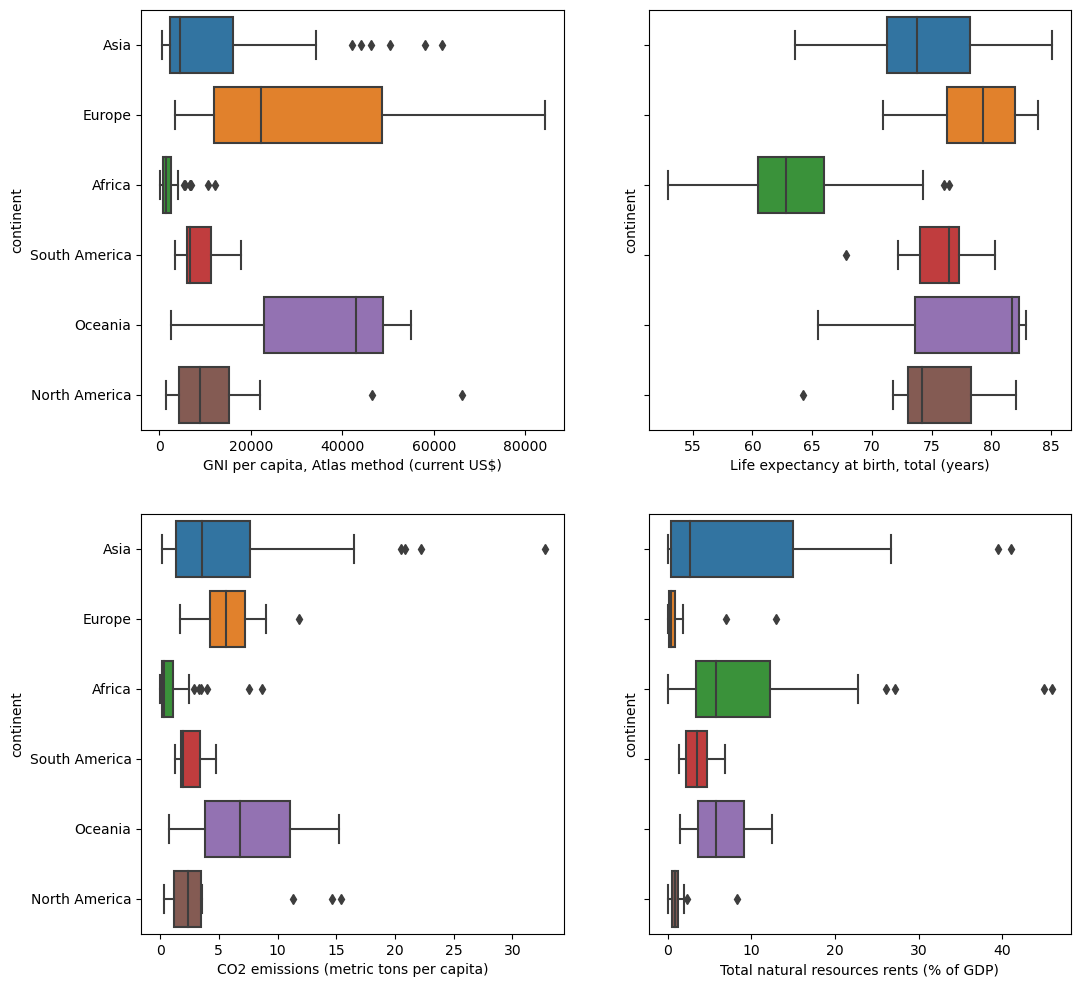

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharey=True)
columns = ['GNI','life_exp','co2','nat_res']
for column, ax in zip(columns, axs.ravel()):
    sns.boxplot(data=ttl_2019, x = column, y= 'continent', ax=ax)
    ax.set_xlabel(indicator_df[indicator_df.name == column]['description'].values[0]);

Oceania has the highest continental GNI per capita. Europe is at 2nd place. Africa is the poorest continent in the world. <br>
People in most parts of the world can expect to live longer than 72, while in Africa the life expectancy is less than 65. <br>
Oceania has the highest average co2 emission per capita, while Asia has some exceptionally high co2 emission countries. <br>
We notice that a few Asia countries have high natual resources rents. We will look into the relationship between natural resources rents and co2 emission later.

The following bubble charts are inspired by Gapminder<br>
https://www.gapminder.org/tools/#$chart-type=bubbles&url=v1

### 3.2 Bubble chart of life expectancy _vs._ education index
This bubble chart shows the education index, life expectancy and population of countries in different continents. The size of the bubble is proportional to the population, the y-axis is the life expectancy, and the X-axis is Education index.

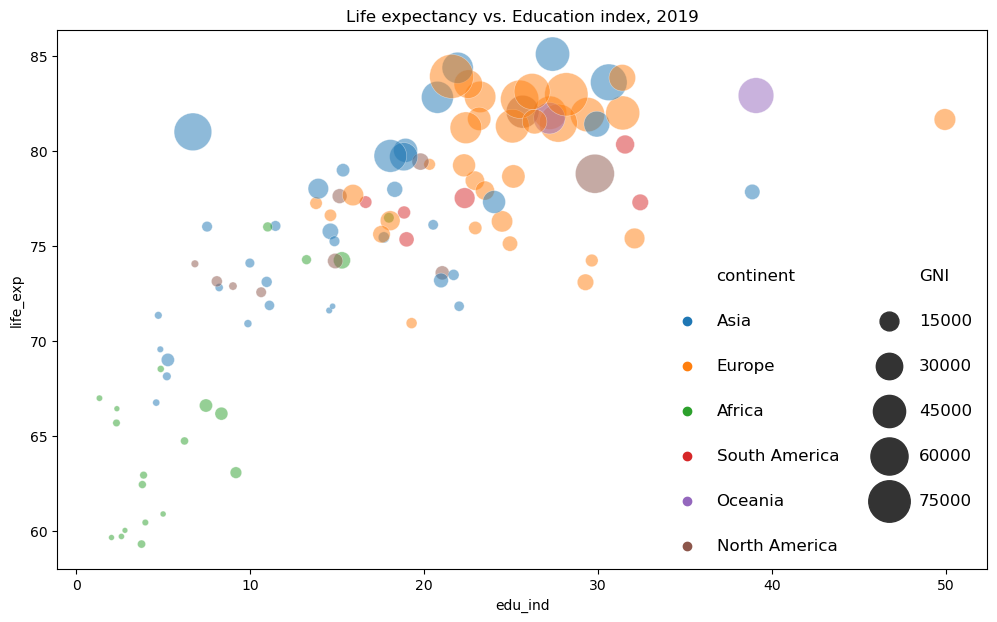

In [61]:
plt.figure(figsize=(12,7))
sns.scatterplot(data = ttl_2019, 
                x='edu_ind', 
                y='life_exp', 
                size = 'GNI',
                hue = 'continent', 
                sizes=(10,1000),
                palette = 'tab10',
                legend = 'brief',
                alpha=0.5)
plt.legend(fontsize = 'large', ncol = 2, frameon=False, labelspacing=1.8)
plt.title('Life expectancy vs. Education index, 2019');

We can see a clear relationship between a country's education level and life expectancy. People in countries having high education indexes living longer lives.

### 3.3 Bubble chart of CO2 emission per capita _vs._ GNI_per_capita (in logarithmic scale)
This bubble chart shows the GNI per capita, CO2 emission per capita, population and life expectancy of different countries. The size of the bubble is proportional to the population, the color darkness is proportional to the life expectency, the y-axis is the CO2 emission per capita, and the X-axis is GNI per capita. China, India, Australia and New Zealand is highlighted.

In [62]:
# Display the needed values for highlighting 
ttl_2019[ttl_2019.country.isin(['China','India','Australia','New Zealand'])]

,country,code,continent,year,pop_tot,GNI,life_exp,co2,nat_res,log_GNI,log_co2,co2_per_GNI,log_co2_per_GNI,edu_ind
241,Australia,AUS,Oceania,2019,2.534022e+07,54900.0,82.900000,15.253618,5.812377,10.913269,2.724817,0.277844,-1.280697,39.095125
1081,China,CHN,Asia,2019,1.407745e+09,10310.0,77.968000,7.605937,1.138781,9.240870,2.028929,0.737724,-0.304185,18.321637
2481,India,IND,Asia,2019,1.383112e+09,2080.0,70.910000,1.775923,1.991762,7.640123,0.574320,0.853809,-0.158048,9.879855
3961,New Zealand,NZL,Oceania,2019,4.979200e+06,43050.0,81.707317,6.830414,1.521985,10.670118,1.921385,0.158662,-1.840977,27.211962


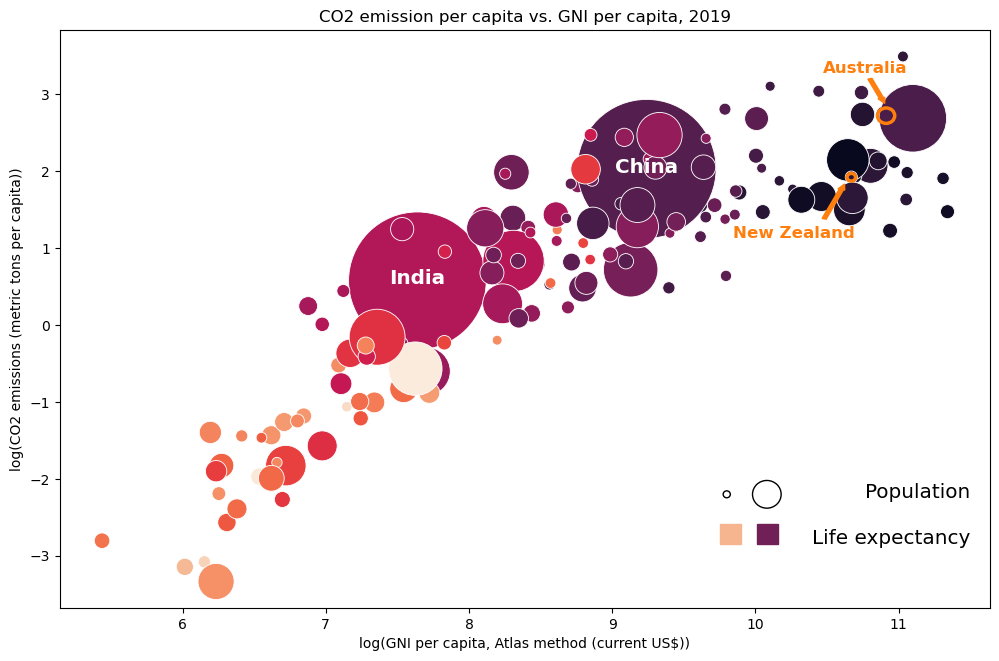

In [63]:
plt.figure(figsize=(12,7.5))
ax = plt.gca()
# Legend for population
circle1 = patches.Ellipse((9.8, -2.2), 0.05, 0.09, color='w', ec='k')
circle2 = patches.Ellipse((10.08, -2.2), 0.2, 0.36, color='w', ec='k')
# Highlight Australia and New Zealand
circle3 = patches.Ellipse((10.67, 1.92), 0.06, 0.1, color='w', ec='C1', fill = False, linewidth = 2.5)
circle4 = patches.Ellipse((10.913, 2.72), 0.12, 0.2, color='w', ec='C1', fill = False, linewidth = 2.5)
# Legend for life expectancy
box1 = patches.Rectangle((9.75, -2.85), width = 0.15, height = 0.27, color=sns.color_palette("rocket")[-1])
box2 = patches.Rectangle((10.01, -2.85), width  = 0.15, height = 0.27, color=sns.color_palette("rocket")[1])
sns.scatterplot(data = ttl_2019, 
                x='log_GNI', 
                y='log_co2', 
                size = 'pop_tot', 
                hue = 'life_exp', 
                sizes=(50,10000), 
                palette = 'rocket_r',
                legend = False)
plt.text(9.24, 1.98, 'China', fontdict = {'ha': 'center', 'size': 'x-large', 'color': 'w', 'weight':'bold'})
plt.text(7.64, 0.53, 'India', fontdict = {'ha': 'center', 'size': 'x-large', 'color': 'w', 'weight':'bold'})
plt.text(10.27, 1.13, 'New Zealand', fontdict = {'ha': 'center', 'size': 'large', 'color': 'C1', 'weight':'bold'})
plt.text(10.77, 3.28, 'Australia', fontdict = {'ha': 'center', 'size': 'large', 'color': 'C1', 'weight':'bold'})
plt.text(11.5, -2.25, 'Population', fontdict = {'ha': 'right', 'size': 'x-large', 'color': 'k'})
plt.text(11.5, -2.85, 'Life expectancy', fontdict = {'ha': 'right', 'size': 'x-large', 'color': 'k'})
plt.arrow(10.48, 1.38, 0.12, 0.38, head_width = 0.05, width = 0.03, color = 'C1')
plt.arrow(10.8, 3.2, 0.08, -0.25, head_width = 0.05, width = 0.03, color = 'C1')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.add_patch(box1)
ax.add_patch(box2)
plt.xlabel('log(' + indicator_df[indicator_df.name == 'GNI']['description'].values[0]+')')
plt.ylabel('log(' + indicator_df[indicator_df.name == 'co2']['description'].values[0]+')')
plt.title('CO2 emission per capita vs. GNI per capita, 2019');

The correlation between GNI per capita and CO2 emissions per capita is strongly positive. Richer countries has higher CO2 emissions per capita.

### 3.3 Bubble chart of CO2 emission per $ GNI _vs._ GNI_per_capita (in logarithmic scale)
This bubble chart shows the GNI per capita, CO2 emission per GNI, population and life expectancy of different countries. The size of the bubble is proportional to the population, the color darkness is proportional to the life expectency, the y-axis is the CO2 emission per GNI, and the X-axis is GNI per capita. China, India, Australia and New Zealand is highlighted.

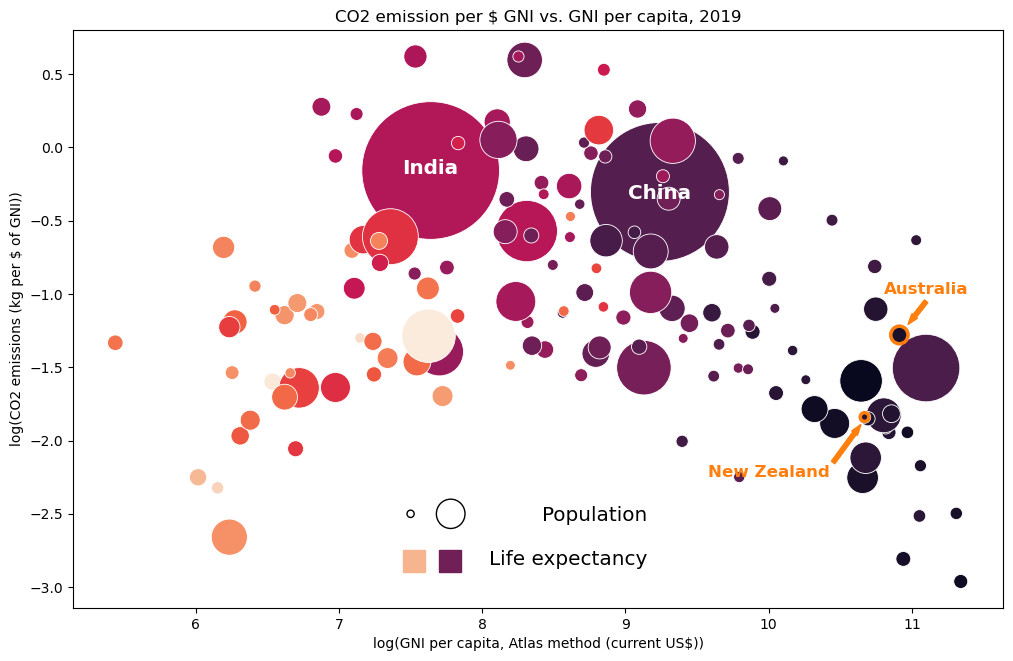

In [93]:
plt.figure(figsize=(12,7.5))
ax = plt.gca()
# Legend for population
circle1 = patches.Ellipse((7.5, -2.5), 0.05, 0.05, color='w', ec='k')
circle2 = patches.Ellipse((7.78, -2.5), 0.2, 0.2, color='w', ec='k')
# Highlight Australia and New Zealand
circle3 = patches.Ellipse((10.67, -1.84), 0.06, 0.06, color='w', ec='C1', fill = False, linewidth = 2.5)
circle4 = patches.Ellipse((10.913, -1.28), 0.12, 0.12, color='w', ec='C1', fill = False, linewidth = 2.5)
# Legend for life expectancy
box1 = patches.Rectangle((7.45, -2.9), width = 0.15, height = 0.15, color=sns.color_palette("rocket")[-1])
box2 = patches.Rectangle((7.7, -2.9), width  = 0.15, height = 0.15, color=sns.color_palette("rocket")[1])
sns.scatterplot(data = ttl_2019, 
                x='log_GNI', 
                y='log_co2_per_GNI', 
                size = 'pop_tot', 
                hue = 'life_exp', 
                sizes=(50,10000), 
                palette = 'rocket_r', 
                legend=False);
plt.text(9.24, -0.35, 'China', fontdict = {'ha': 'center', 'size': 'x-large', 'color': 'w', 'weight':'bold'})
plt.text(7.64, -0.18, 'India', fontdict = {'ha': 'center', 'size': 'x-large', 'color': 'w', 'weight':'bold'})
plt.text(10, -2.25, 'New Zealand', fontdict = {'ha': 'center', 'size': 'large', 'color': 'C1', 'weight':'bold'})
plt.text(11.1, -1, 'Australia', fontdict = {'ha': 'center', 'size': 'large', 'color': 'C1', 'weight':'bold'})
plt.text(9.15, -2.55, 'Population', fontdict = {'ha': 'right', 'size': 'x-large', 'color': 'k'})
plt.text(9.15, -2.85, 'Life expectancy', fontdict = {'ha': 'right', 'size': 'x-large', 'color': 'k'})
plt.arrow(10.45, -2.15, 0.15, 0.2, head_width = 0.05, width = 0.03, color = 'C1')
plt.arrow(11.1, -1.05, -0.08, -0.1, head_width = 0.05, width = 0.03, color = 'C1')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.add_patch(box1)
ax.add_patch(box2)
plt.xlabel('log(' + indicator_df[indicator_df.name == 'GNI']['description'].values[0]+')')
plt.ylabel('log(' + indicator_df[indicator_df.name == 'co2_per_GNI']['description'].values[0]+')')
plt.title('CO2 emission per $ GNI vs. GNI per capita, 2019');

However, when we change the y-axis to CO2 emission per dollar income, we can see a entirely different picture. The relationship between GNI per capita and CO2 emissions per dollar income shows a parabolic shape. When the GNI per capita level is low, growing in income leads to a higher CO2 emissions per dollar income. When the GNI per capita reaches the turning point, CO2 emissions per dollar income starts to decrease as GNI per capita increases. 
More developed countries emit less CO2 when generating each dollar of income.

### 3.4 CO2 emission of resources exporters
This histogram shows overall distribution of total natural resources rents. 

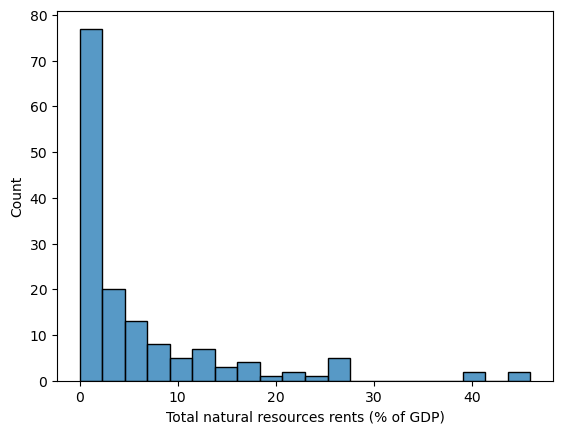

In [65]:
sns.histplot(data = ttl_2019, x = 'nat_res', bins=20)
plt.xlabel(indicator_df[indicator_df.name == 'nat_res']['description'].values[0]);

Most countries have total natural resources rents less than 2% of GDP. The countries with high natural resource rents are typically fossil fuel or mineral exporters.

In [66]:
# Assign a country as resources exporter if it has total natural resources rents greater than 5% of GDP
with pd.option_context('mode.chained_assignment', None):
    ttl_2019['res_coun'] = np.where(ttl_2019['nat_res'] > 5, 1, 0)

In [67]:
print('The proportion of natural resources exporting countries: ' + str(ttl_2019['res_coun'].mean()))

The proportion of natural resources exporting countries: 0.3116883116883117


In [68]:
print('The natural resources exporting countries are: ')
print([*ttl_2019[ttl_2019.res_coun == 1]['country']])

The natural resources exporting countries are: 
['Algeria', 'Angola', 'Australia', 'Azerbaijan', 'Bahrain', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Ecuador', 'Equatorial Guinea', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea-Bissau', 'Iran, Islamic Rep.', 'Iraq', 'Kazakhstan', 'Kuwait', 'Kyrgyz Republic', 'Liberia', 'Libya', 'Malaysia', 'Mali', 'Mongolia', 'Mozambique', 'Myanmar', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Papua New Guinea', 'Qatar', 'Russian Federation', 'Saudi Arabia', 'Sierra Leone', 'Somalia', 'Tajikistan', 'Trinidad and Tobago', 'Turkmenistan', 'Uganda', 'United Arab Emirates', 'Uzbekistan', 'Zambia', 'Zimbabwe']


The following plot shows the GNI per capita, CO2 emission per GNI, population of different countries. The size of the bubble is proportional to the population, the y-axis is the CO2 emission per GNI, and the X-axis is GNI per capita. The natural resources exporting countries are in orange color.

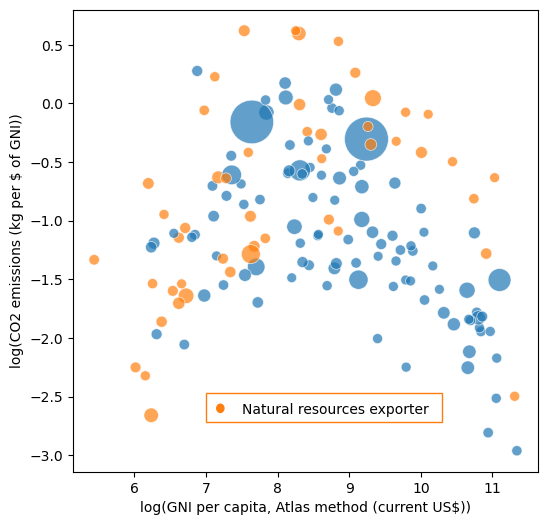

In [69]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = ttl_2019, 
                x='log_GNI', 
                y='log_co2_per_GNI', 
                size = 'pop_tot', 
                hue = 'res_coun', # Highlighting natural resources exporters
                sizes=(50,1000),
                alpha=0.7,
                legend=False)
ax = plt.gca()
circle = patches.Ellipse((7.2, -2.6), 0.1, 0.07, color='C1')
rectangle = patches.Rectangle((7, -2.72), 3.3, 0.25, ec='C1', fill = False)
ax.add_patch(circle)
ax.add_patch(rectangle)
plt.text(7.5, -2.65, 'Natural resources exporter')
plt.xlabel('log(' + indicator_df[indicator_df.name == 'GNI']['description'].values[0]+')')
plt.ylabel('log(' + indicator_df[indicator_df.name == 'co2_per_GNI']['description'].values[0]+')');

Comparing to other countries at similar GNI per capita level, natural resources exporters seem to have higher CO2 emission per GNI. Thus we form our hypothesis for testing: _Natural resource-exporting countries have a higher average CO2 emission per GNI than other countries._

### 3.5 Correlation matrix between indicators
The following matrix shows the correlations between indicators. 

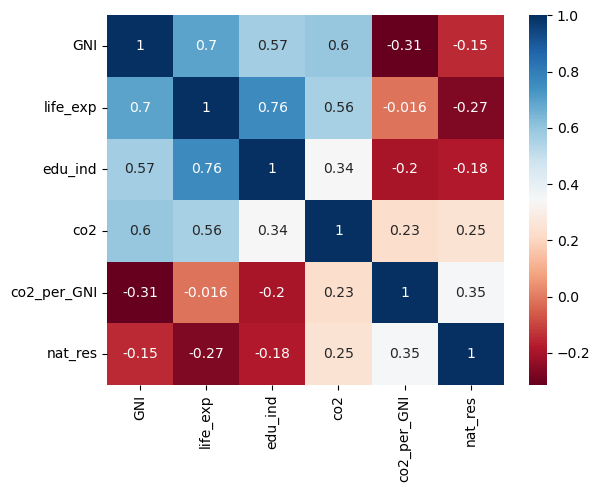

In [70]:
corr_2019 = ttl_2019[['GNI','life_exp', 'edu_ind', 'co2', 'co2_per_GNI', 'nat_res']].corr()
sns.heatmap(corr_2019, annot=True, cmap='RdBu');

The strongest positive correlation comes from `edu_ind` and `life_exp`. It is also clear that `GNI` has strong correlations with `life_exp` and `co2`. excluded. `GNI` has a weak negative correlations with `co2_per_GNI`, while `nat_res` has a weak positive correlation with `co2_per_GNI`. 

# 4. The dynamics of CO<sub>2</sub> emission across years
After studying the cross-sectional relationship between indicators, we investigate the change of CO2 emission over time.

### 4.0 Prepare the dataset

Select the year range when co2 data is available, and the desired columns.
Sort dataset by country and ascending year.

In [71]:
ttl_co2 = ttl[(ttl.year >= 1990) & (ttl.year <= 2019)][['country','code','continent','year','pop_tot','GNI','co2','co2_per_GNI', 'nat_res']]
ttl_co2 = ttl_co2.sort_values(['country', 'year'])

Fill the missing values using linear interpolation:

In [72]:
with pd.option_context('mode.chained_assignment', None):
    ttl_co2[['pop_tot','GNI','co2','co2_per_GNI', 'nat_res']] = ttl_co2.groupby('country', group_keys=False)\
                                                                [['pop_tot','GNI','co2','co2_per_GNI','nat_res']]\
                                                                .apply(lambda x: x.interpolate())

In [73]:
ttl_co2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4620 entries, 30 to 6121
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      4620 non-null   object 
 1   code         4620 non-null   object 
 2   continent    4620 non-null   object 
 3   year         4620 non-null   int32  
 4   pop_tot      4620 non-null   float64
 5   GNI          4349 non-null   float64
 6   co2          4527 non-null   float64
 7   co2_per_GNI  4264 non-null   float64
 8   nat_res      4510 non-null   float64
dtypes: float64(5), int32(1), object(3)
memory usage: 342.9+ KB


### 4.1 Global average CO2 emission across years

Calculate the world average CO2 emission per capita and CO2 emission per $ GNI:

In [74]:
co2_years = ttl_co2.groupby('year').apply(lambda x: (x['co2'] * x['pop_tot']).sum()/x['pop_tot'].sum()).to_frame()
co2_years.columns = ['co2']

In [75]:
co2_years = co2_years.assign(co2_per_GNI = ttl_co2.groupby('year').\
                             apply(lambda x: (x['co2_per_GNI'] * x['pop_tot'] * x['GNI']).sum()/(x['pop_tot'] * x['GNI']).sum()))

In [76]:
co2_years.head()

,co2,co2_per_GNI
year,,
1990,3.864051,0.772343
1991,3.821371,0.837818
1992,3.761122,0.805580
1993,3.722279,0.800606
1994,3.681449,0.757629


This plot shows the changes in global co2 emissions per capita and co2 emission per GNI  from 1990 to 2019. The left y-axis is CO2 emission per capita, the right y-axis is CO2 emission per GNI.

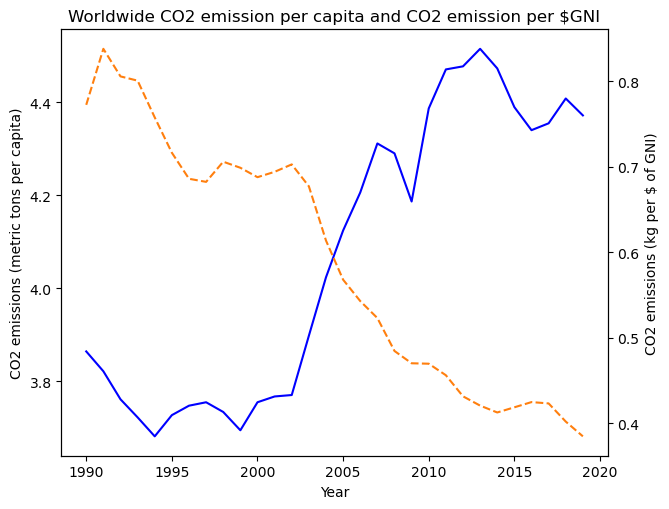

In [77]:
fig, ax1 = plt.subplots()
ax1.plot(co2_years.co2, color='b')
ax2 = ax1.twinx()
ax2.plot(co2_years.co2_per_GNI, color='C1', linestyle='--')
fig.tight_layout()
ax1.set_xlabel('Year')
ax1.set_ylabel(indicator_df[indicator_df.name == 'co2']['description'].values[0])
ax2.set_ylabel(indicator_df[indicator_df.name == 'co2_per_GNI']['description'].values[0]);
plt.title('Worldwide CO2 emission per capita and CO2 emission per $GNI');

We can that while CO2 emission per capita keeps escalating over the past three decades, CO2 emission per GNI shows a declining trend. We could expect that CO2 emission per capita will finally come to a climax and start to decrease when CO2 emission per GNI is reduced to a low enough level.

### 4.2 Persistence of the negative correlation between GNI per capita and CO2 emission per GNI

In the 2019 cross-sectional analysis, we found a negative correlation (-0.31) between GNI per capita and CO2 emission per GNI. Now we examine the evolvement of this correlation over time.

In [78]:
co2_GNI_corr = ttl_co2.groupby('year')[['GNI','co2_per_GNI']].corr().unstack().iloc[:,1]

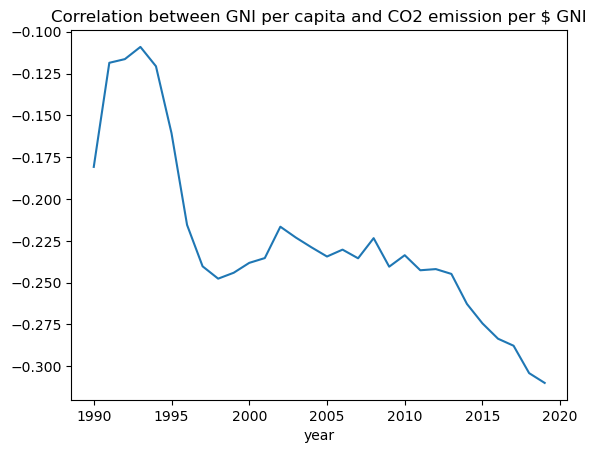

In [79]:
co2_GNI_corr.plot()
plt.title('Correlation between GNI per capita and CO2 emission per $ GNI');

We can see that the correlation between between GNI per capita and CO2 emission per GNI was consistently negative over the whole time range, and lowered from around -0.23 to -0.31 during the past decade, indicating that developed countries might have contributed more in the reduction of CO2 emission per GNI. 

### 4.3 The impact of CO2 emission reduction on future economic growth

Next we investigate the impact of reduction in CO2 emission per GNI on next year's GNI growth. <br>
For each country, calculate the percentage change (growth) in GNI per capita and the negative percentage change (reduction) in CO2 emission per \$ GNI. 

In [80]:
with pd.option_context('mode.chained_assignment', None):
    ttl_co2['GNI_growth'] = ttl_co2.groupby('country')['GNI'].pct_change()*100
    ttl_co2['co2_redu'] = - ttl_co2.groupby('country')['co2_per_GNI'].pct_change()*100

In [81]:
with pd.option_context('mode.chained_assignment', None):
    ttl_co2['GNI_growth_lead'] = ttl_co2.groupby('country')['GNI_growth'].shift(-1)

Shift the GNI growth rate backward by one year so that the value of one year represents the next year's growth rate. <br>
Select the desired columns and drop NAs.

In [82]:
gnig_co2r = ttl_co2[['GNI_growth_lead','co2_redu']].dropna()
gnig_co2r.describe()

,GNI_growth_lead,co2_redu
count,3964.000000,3964.000000
mean,5.641852,-inf
std,13.013764,NaN
min,-63.333333,-inf
25%,-0.802429,-3.299166
50%,4.597701,3.609538
75%,10.957319,9.863101
max,238.461538,100.000000


Both `GNI_growth_lead` and `co2_redu` columns contains some extreme and/or invalid values, which may disturb the analysis. We remove the data below the 0.5th percentile and above the 99.5th percentile.

In [83]:
co2r_99 = gnig_co2r.quantile([0.005,0.995])
co2r_99

,GNI_growth_lead,co2_redu
0.005,-28.726891,-62.648724
0.995,50.140152,40.210939


In [84]:
gnig_co2r = gnig_co2r[(gnig_co2r.GNI_growth_lead > co2r_99.iloc[0,0]) \
                      & (gnig_co2r.GNI_growth_lead < co2r_99.iloc[1,0]) \
                      & (gnig_co2r.co2_redu > co2r_99.iloc[0,1]) \
                      & (gnig_co2r.co2_redu < co2r_99.iloc[1,1])]
gnig_co2r.describe()

,GNI_growth_lead,co2_redu
count,3891.000000,3891.000000
mean,5.404345,2.830724
std,10.044078,11.699209
min,-28.571429,-62.581071
25%,-0.698099,-3.138090
50%,4.606365,3.637059
75%,10.869565,9.792627
max,50.000000,40.114828


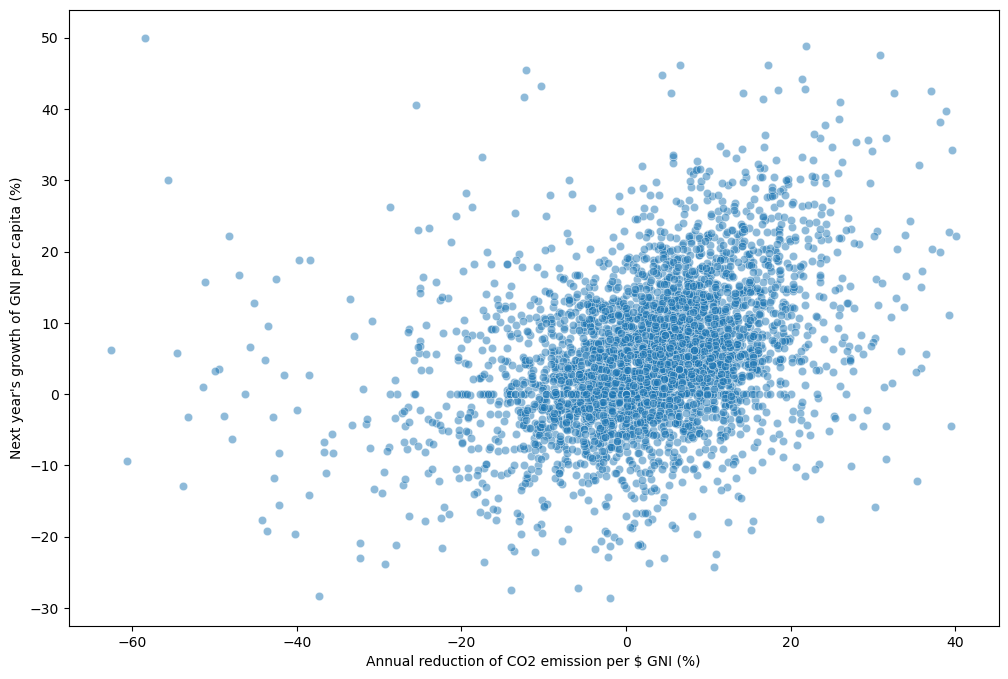

In [85]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=gnig_co2r, x='co2_redu', y='GNI_growth_lead', alpha=0.5)
plt.xlabel('Annual reduction of CO2 emission per $ GNI (%)') 
plt.ylabel('Next year\'s growth of GNI per capita (%)');

The above figure shows the relationship between CO2 emission reduction and next year's economic growth. We can see a rough positive correlation.<br>
Calculate the correlation coefficient between annual reduction on CO2 emission per \$GNI and next year's growth of GNI per capita.

In [86]:
corr_coef = gnig_co2r.corr().iloc[0,1]
print('The correlation coefficient between between annual reduction on CO2 emission per $ GNI and next year\'s growth of GNI per capita:' \
      +'\n' + str(corr_coef))

The correlation coefficient between between annual reduction on CO2 emission per $ GNI and next year's growth of GNI per capita:
0.36424569414279223


This positive correlation is not strong (in magnitude) but is statistically significant due to the large sample size (3667 observations).

## **5. Hypothesis test**

In the last part of this analysis, we test the hypothesis formed in section 3: <br>
**Natural resource-exporting countries have a higher average CO2 emission per \$ GNI than other countries.**

First, for each year, divide countries into four quartiles in terms of total natural resources rents:

In [87]:
with pd.option_context('mode.chained_assignment', None):
    ttl_co2['nat_res_q'] = ttl_co2.groupby('year')['nat_res'].transform(lambda x: pd.qcut(x, 4, labels = range(1,5)))

Countries belong to the last (fourth) quartile are identified as natural resources exporters.

In [88]:
nat_res = ttl_co2[['country','year','pop_tot','GNI','co2_per_GNI','nat_res_q']]
with pd.option_context('mode.chained_assignment', None):
    nat_res['res_coun'] = np.where(nat_res['nat_res_q'] == 4, 1, 0)

For each year, calculate the average CO2 emission per \$ GNI for natural resources exporters and other countries, respectively.

In [89]:
nat_res_hyp = nat_res.groupby(['year', 'res_coun']) \
                     .apply(lambda x: (x['co2_per_GNI'] * x['pop_tot'] * x['GNI']).sum()/(x['pop_tot'] * x['GNI']).sum()).to_frame()
nat_res_hyp.columns = ['co2_per_GNI']
nat_res_hyp = nat_res_hyp.reset_index().pivot(index='year', columns='res_coun', values = 'co2_per_GNI')

In [90]:
nat_res_hyp.head()

res_coun,0,1
year,,
1990,0.753027,1.409906
1991,0.815455,1.604499
1992,0.780150,1.736733
1993,0.770757,1.977884
1994,0.729907,1.991485


Thus we have 30 observations of the average CO2 emission per \$ GNI from each country group. We define our hypothesis as: <br>
>**H<sub>0</sub>:** There is no difference between the average CO2 emission per \$ GNI of natural resources exporters and other countries. <br>
**H<sub>1</sub>:** The average CO2 emission per \$ GNI of natural resources exporters is greater than that of other countries.

In [91]:
t, p = stats.ttest_rel(nat_res_hyp.iloc[:,1], nat_res_hyp.iloc[:,0], alternative = 'greater')

Test result:

In [92]:
print("p-value is: " + str(p) + "\n" + "We reject our null hypothesis.") \
if p < 0.05 else print("p-value is" + str(p) + "\n" + "We fail to reject our null hypothesis.")

p-value is: 2.3282193593605613e-10
We reject our null hypothesis.


We reject our null hypothesis with a virtually zero p-value and conclude that natural resource-exporting countries do have a higher average CO2 emission per $ GNI than other countries.

## **6. Conclusion**
The World Bank database is a massive repository socioeconomic, financial, environmental, and health-related data. In this analysis, we have collected the data of the following indicators: 'GNI per capita', 'Life expectancy', 'Compulsory education duration', 'Tertiary enrollment', 'CO2 emission per capita' and 'Total natural resources rent', for more than 150 countries across 40 years. The CO2 emission data is available from 1990 to 2019. 

We first conducted a cross-sectional analysis on the relationship between indicators as of the year 2019. CO2 emissions per capita has a strongly positive correlation with GNI per capita. However, the relationship between GNI per capita and CO2 emissions per GNI shows a parabolic shape. CO2 emissions per GNI starts to decrease as GNI per capita increases when the GNI per capita reaches a turning point.  has a negative correlation with  has  CO2 emissions per GNI has a weak negative correlation with GNI per capita but a positive correlation with percentage natural resources rents.

We then analysed the changes in CO2 emission during the past 30 years. CO2 emission per capita was increasing over time while CO2 emission per GNI decreasing. The negative correlation between GNI per capita and CO2 emissions per GNI is persistent across years. Reducing CO2 emssion has a positive impact on next year's economic growth.

Finally we performed a hypothesis test on the difference of average CO2 emission per GNI of natural resource exporters and of other countries. We rejected our null hypothesis and conclude that natural resource-exporting countries have a greater average CO2 emission per GNI.

The analysis can be extended in the future by including more indicators and developing predictive models.
